<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/Restoration/Sampling_TV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling from posterior distributions with a TV prior

**Authors:**
* [Julie Delon](https://github.com/judelo) 
* Lucía Bouza

## Reminders on the sampling of $e^{-H}$

In the following, we wish to draw samples from the distribution 
$$ \pi_{H}(x) \propto e^{-H(x)},$$
assuming that $\int_x e^{-H(x)} < +\infty$.
For instance, if we want to know what images with a TV prior look like, we can choose $H(x) = \beta \mathrm{TV}(x) + \epsilon \|x\|^2$ for a very small value of $\epsilon$ (the term $\epsilon \|x\|^2$ ensures  $\int_x e^{-H(x)} < +\infty$). 


In order to draw from $ \pi_{H}$, we will use a Metropolis algorithm, inspired by what is used in 

[Louchet, C., & Moisan, L. (2008, August). Total variation denoising using posterior expectation, EUSIPCO 2008](https://hal.archives-ouvertes.fr/hal-00258849/file/lm08ok.pdf). 

 We will draw $n_r\times n_c$ images and we call $\Gamma$ the discrete grid $\{1,\dots,n_r\}\times  \{1,\dots,n_c\}$. 

## Metropolis algorithm for the simulation of $X\sim \pi_{H}$
1. *Initialization : draw a $n_r\times n_c$ random image $x_0$ (realization of a i.i.d. white noise for instance)*
2. *for k from 1 to N (with N large)*
    + *draw, independently, a pixel $(i,j)$ with a uniform law on the grid  $\Gamma$, a variable $z\sim \mathcal{U}([0,1])$, and a variable $t \sim \mathcal{U}([-\alpha,\alpha])$* ($\alpha$ is a parameter of the algorithm)
    + *call $x_{temp}$ the image obtained by replacing $x_k(i,j)$ by $x_k(i,j) + t$ (not touching other pixels)*
    + *if $z < e^{-(H(x_{temp}) - H(x_k) ) }$, define $x_{k+1} = x_{temp}$ and define $x_{k+1}=x_k$ otherwise.*
3. *Return $x_N$.* 

## Importing packages

Below is a list of packages required in the notebook.

* `matplotlib.pyplot, BytesIO, urlopen` (load and display images)
* `time` (to measure time spend on the algorithms)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO                 # used for importing online images 
from urllib.request import urlopen     # used for importing online images 
import time

## Helper functions

In the next cell we define some functions for displaying images. 

In [2]:
#@title Helper Functions

# Function to display two images
def printImages(a, b, title_a, title_b, size1, size2):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(size1, size1))
    axes[0].set_title(title_a)
    axes[0].imshow(a,cmap='gray',vmin=0,vmax=1)
    axes[1].set_title(title_b)
    axes[1].imshow(b,cmap='gray',vmin=0,vmax=1)
    fig.tight_layout()
    plt.show()

# Function to display four images
def print4Images(a, b, c, d, title_a, title_b, title_c, title_d, size1, size2):

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(size1, size1))
    axes[0].set_title(title_a)
    axes[0].imshow(a,cmap='gray',vmin=0,vmax=1)
    axes[1].set_title(title_b)
    axes[1].imshow(b,cmap='gray',vmin=0,vmax=1)
    axes[2].set_title(title_c)
    axes[2].imshow(c,cmap='gray',vmin=0,vmax=1)
    axes[3].set_title(title_d)
    axes[3].imshow(d,cmap='gray')
    fig.tight_layout()
    plt.show()

## Sampling $e^{- \beta \mathrm{TV}-\epsilon \|.\|_2^2}$

We wish to implement the previous algorithm to draw samples from the distribution $e^{-\beta \mathrm{TV}-\epsilon \|.\|^2}$, where we recall that (for simplicity we use the norm 1 version of TV here):
$$TV(u) = \sum_{i,j} |u(i+1,j) - u(i,j)|+ |u(i,j+1) - u(i,j)|.$$

To implement the Metropolis algorithm, we could loop on the pixels of $u$, but the algorithm would be atrociously slow. A solution is to parallelize the function on independent pixels to speed up the computations: pixels at distance larger than 2 can be modified simultaneously, but we should be careful to compute $z < e^{-(H(x_{temp}) - H(x_k) ) }$ independently for each of these modified pixels in order to decide if you keep the local modification or not at the pixel. 

- To do so, you can start by writing a function `deltaTV_pointwise ` which computes the map of differences really involved in the computation of $H(x_{temp})-H(x_k)$ when the pixel $(i,j)$ is modified.  
Indeed, observe that changing the value at pixel $(i,j)$ only affects the total variation at $(i,j)$, $(i-1,j)$ and $(i,j-1)$. 
In the total sum $TV(u)$, the values affected by these modifications are thus all values involving $u(i,j)$, i.e.
$$|u(i+1,j) - u(i,j)|+ |u(i,j+1) - u(i,j)|+ |u(i,j) - u(i-1,j)|+ |u(i,j) - u(i,j-1)|.$$
For simplicity you can assume that your image is periodic and make use of the function ``np.rol``.


> ![Text](https://raw.githubusercontent.com/storimaging/Images/main/SupportImages/TotalVariation.jpg) 


In [3]:
#@title Pointwise differences computations
# Define total variation of an image
def TV1(u):
    return  np.sum(np.sum(np.abs(np.roll(u,1,axis=0)- u)+np.abs(np.roll(u,1,axis=1) - u)))


# compute TV local differences at each pixel of an image 
def TVaffected(x):
    """
    calculates the part of TV at each point of image x
    at the end TV(x) is np.sum(np.sum(TVaffected(x)))
    """
    return np.abs(np.roll(x,1,axis=0)- x) + np.abs(np.roll(x,1,axis=1) - x) + np.abs(np.roll(x,-1,axis=0)- x) + np.abs(np.roll(x,-1,axis=1) - x)


def deltaTV_pointwise(x,xtemp, **opts):
    """
    delta TV for TV1
    computes at each point x the variation of H between x and xtemp
    """
    epsilon = opts.get('epsilon', 1e-4)
    beta = opts.get('beta', 1)
    return  beta*( TVaffected(xtemp) - TVaffected(x)) + epsilon*(xtemp**2-x**2) 


- Using the previous functions, you can implement the Metropolis algorithm to sample $e^{-H}$. 

In [4]:
#@title Metropolis
# one step of the Metropolis algorithm
def transition_all_TV(x,alpha, delta_pointwise, **opts): 
    """
    step of metropolis algorithm paralellizing the process on pixels
    parameters:
      - image x
      - alpha
      - function delta_pointwise: changes according to selected sampling
      - opts: changes according to selected sampling
    """
    nr,nc = x.shape
    # to parallelize the process we will select a grid of independent pixels with distance 2 between them.
    # select init pixel among the four on the top left corner to draw a grid of independent pixels
    i=np.random.randint(2) 
    j=np.random.randint(2)
    grid = np.zeros((nr,nc))
    grid[i:nr:2,j:nc:2] = 1

    # xtemp =  x + t for pixels of the grid. xtemp = x otherwise.   
    t = np.random.uniform(-alpha, alpha, size=(nr,nc))
    xtemp = np.copy(x) 
    xtemp[grid==1] = x[grid==1] + t[grid==1]

    # decide for each point if we apply the transition or not
    z = np.random.uniform(0, 1, size=(nr,nc))
    diff = np.exp(-delta_pointwise(x, xtemp, **opts) ) - z
    xtemp[diff<0] = x[diff<0]
    return xtemp

######
## Sampling TV
######


# Metropolis algorithm
def metropolis_TV1(x,alpha,N, **opts):
    """
    Metropolis algorithm using TVL1
    """
    for t in range(N):
        x=transition_all_TV(x,alpha,deltaTV_pointwise, **opts)
    return x



- Now, start with a small value of $\beta$ (1 for instance) and draw several samples of the distributions, then increase the value of $\beta$. What do you observe?  
- Observe also the variation of $TV(u)$ along iterations (and the range of values of these realizations), for different values of $\beta$.

In [5]:
# initializations for display results
out = []
tv_out = []
t0 = time.time()

# Parametrers
noise = np.random.rand(50,50)
N = int(1e4) # number of iterations 
alpha = 0.1  # parameter of the algorithm
epsilon = 1e-12 # for the quadratic term
betas = [1, 10, 100] 

for beta in betas:
    opts =  dict(beta=beta, epsilon=epsilon)
    x = np.copy(noise)  # initialization    
    temp = metropolis_TV1(x,alpha,N, **opts)
    out = out + [temp]
    tv_out = tv_out + [TV1(temp)]
    
t1 = time.time() 
print("time spent (on 3 runs): ", t1-t0)

time spent (on 3 runs):  22.535602807998657


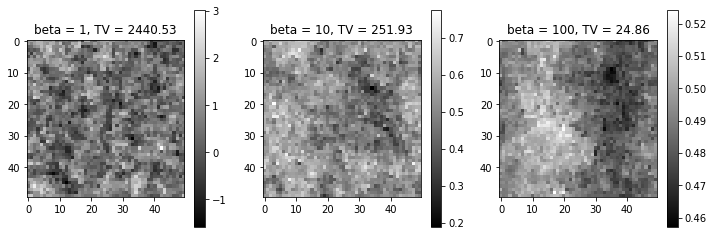

In [6]:
# Print results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i in range(len(betas)):
    dr = axes[i].imshow(out[i],cmap='gray')
    fig.colorbar(dr,ax = axes[i])
    axes[i].set_title('beta = {}, TV = {:.2f}'.format( betas[i], tv_out[i]))
    


## Sampling $e^{-\left(\lambda \mathrm{TV(u)+\|u-u_0\|^2/{\sigma^2}}\right)}$

Now, we wish to sample from the distribution 
$$\pi(u) \propto e^{-\left(\lambda \mathrm{TV(u)+\|u-u_0\|^2/{\sigma^2}}\right)}$$

We can use exactly the same approach as before.
- Implement the previous algorithm to draw samples from the distribution $\pi$. Again write everything locally and parallelize on independent pixels for efficiency.
- Implement your algorithm so you can compute the average value of all samples after a burn-in phase. If $x_t$ is the sample at iteration $t$, you can do it iteratively by initializing the mean to 0 and updating at iteration t:
$$x_{mean} = t/(t+1)*x_{mean} + 1/(t+1)*x_{t}$$
- using the same trick, compute the standard deviation of your samples
- as a sanity check, you can observe the number of pixels where the perturbation is accepted at each iteration. This number should be a non trivial proportion of the modified pixels.
- try different initializations for the Markov chain. Does your average posterior depend on your initialization ? 
- compare the average posterior $x_{mean}$ with the MAP obtained with the Chambolle-Pock algorithm (see the notebook on **variationnal approaches for image restoration**). In particular, observe that the staircasing present in the TV MAP doest not appear in the average posterior, as shown in 
[Louchet, C., & Moisan, L. (2008, August). Total variation denoising using posterior expectation, EUSIPCO 2008](https://hal.archives-ouvertes.fr/hal-00258849/file/lm08ok.pdf). 

The following cell contains the code for the Chambolle-Pock algorithm (see the notebook on **variationnal approaches for image restoration**) to compute MAP restoration for TVL2 / TVL1 formulations.


In [7]:
#@title Chambolle-Pock for TVL2 / TVL2 / TVL2 with diagonal A

def div(cx,cy):
    """
    cy and cy are coordonates of a vector field.
    #the function computes the discrete divergence of this vector field
    """
    nr,nc=cx.shape

    ddx=np.zeros((nr,nc))
    ddy=np.zeros((nr,nc))

    ddx[:,1:-1]=cx[:,1:-1]-cx[:,0:-2]
    ddx[:,0]=cx[:,0]
    ddx[:,-1]=-cx[:,-2]
  
    ddy[1:-1,:]=cy[1:-1,:]-cy[0:-2,:]
    ddy[0,:]=cy[0,:]
    ddy[-1,:]=-cy[-2,:]
 
    d=ddx+ddy

    return d


def grad(im):
    """
    computes the gradient of the image 'im'
    """
    nr,nc=im.shape
  
    gx = im[:,1:]-im[:,0:-1]
    gx = np.block([gx,np.zeros((nr,1))])

    gy =im[1:,:]-im[0:-1,:]
    gy=np.block([[gy],[np.zeros((1,nc))]])
    return gx,gy

def chambolle_pock_prox_TV(TV,ub,lambd,niter, **opts):
    """
    the function solves the problem
    - TVL2
       argmin_u   1/2 \| u - ub\|^2 + \lambda TV(u)
    - or TVL2A
       argmin_u   1/2 \| Au - ub\|^2 + \lambda TV(u)
       with A = diagonal matrix represented by the mask send as an opt on parameters
    - or TVL1
       argmin_u   1/2 \| u - ub\|_1 + \lambda TV(u)
    with TV(u) = \sum_i \|\nabla u (i) \|_2
    uses niter iterations of Chambolle-Pock
    """

    nr,nc = ub.shape
    ut = np.copy(ub)
    ubar = np.copy(ut)
    p = np.zeros((nr,nc,2))
    tau = 0.9/np.sqrt(8*lambd**2)
    sigma = 0.9/np.sqrt(8*lambd**2) 
    theta = 1
    
    # For TVL2A case
    mask = opts.get('mask', np.ones_like(ub))
    
    for k in range(niter):
        # Calcul de proxF
        ux,uy  = grad(ubar)
        p = p + sigma*lambd*np.stack((ux,uy),axis=2)
        normep = np.sqrt(p[:,:,0]**2+p[:,:,1]**2)
        normep = normep*(normep>1) + (normep<=1)
        p[:,:,0] = p[:,:,0]/normep
        p[:,:,1] = p[:,:,1]/normep

        # Calcul de proxG
        d=div(p[:,:,0],p[:,:,1])
        if (TV == "TVL2"):
            unew = 1/(1+tau)*(ut+tau*lambd*d+tau*ub) 
        elif (TV == "TVL2A"):    
            unew = 1/(1+tau*mask)*(ut+tau*lambd*d+tau*mask*ub)
        else:
            uaux = ut+tau*lambd*d
            unew = (uaux-tau)*(uaux-ub>tau)+(uaux+tau)*(uaux-ub<-tau)+ub*(abs(uaux-ub)<=tau)
        
        # Extragradient step
        ubar = unew+theta*(unew-ut)
        ut = np.copy(unew)
           
    return ut

The code to sample $\frac 1 Z e^{-\left(\lambda \mathrm{TV(u)+\|u-u_0\|^2/{\sigma^2}}\right)}$ is almost the same as above, with the additional data term, and the slight modification to compute the empirical mean of the Markov chain.  


In [8]:
#@title Sampling $\frac 1 Z e^{-\left(\lambda \mathrm{TV(u)+\|u-u_0\|^2/{\sigma^2}}\right)}$

######
## Functions common to all methods
######

# Define Total variation L2 of an image. ub is the noisy image
def TVL2(x,ub,sigma,lambd):
    return  np.sum(np.sum(0.5*(x-ub)**2))/sigma**2 +  lambd*TV1(x)  

######
## Sampling TVL2
######

def deltaTVL2_pointwise(x,xtemp, **opts):
    """
    delta TV for TVL2
    """
    ub = opts.get('ub', x)
    sigma = opts.get('sigma', 1)
    lambd = opts.get('lambd', 1)
    return  lambd*( TVaffected(xtemp) - TVaffected(x)) + 0.5*((xtemp-ub)**2- (x-ub)**2)/(sigma**2) 


def metropolis_TVL2(x,alpha,N, **opts):
    """
    Metropolis algorithm using TVL2
    calculates also mean and standard deviation
    """
    t_burnin = int(N/10)
    nr,nc = x.shape
    xmean = np.zeros((nr,nc))
    x2 = np.zeros((nr,nc))
    
    for t in range(N):
        x= transition_all_TV(x,alpha,deltaTVL2_pointwise, **opts)
        # update the mean
        if t >= t_burnin:
            tb = t - t_burnin
            xmean = tb/(tb+1)*xmean + 1/(tb+1)*x
            x2    = tb/(tb+1)*x2 + 1/(tb+1)*x**2
    stdx = np.sqrt(x2 - xmean**2)
    return x,xmean,stdx



In the next cell we will create a noisy image. We will crop the original image to accelerate the process. 

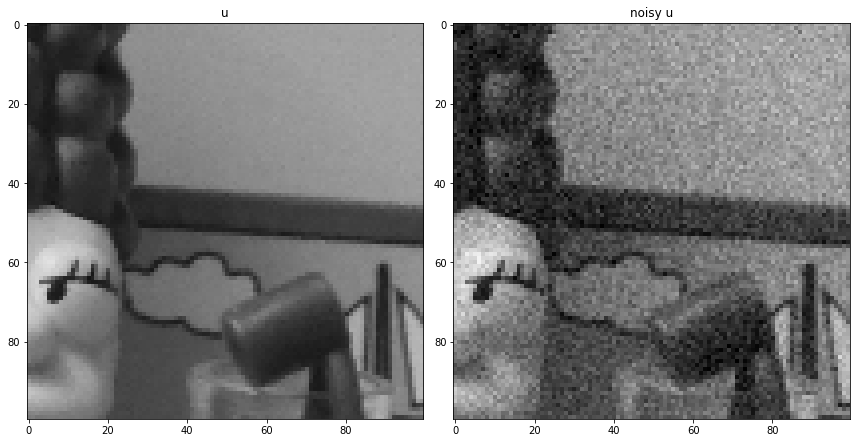

In [9]:
# Read image
IMG = "https://raw.githubusercontent.com/storimaging/Images/main/img/simpson_nb512.png"
u = plt.imread(BytesIO(urlopen(IMG).read()))

# Crop image: start with small images for your experimentations
n = 100    
i = 100
u = u[i:i+n,i:i+n]

# Add noise
nr,nc = u.shape
sigma = 0.05
ub = u + sigma*np.random.randn(nr,nc)

# Print images
printImages(u, ub, "u", "noisy u", 12, 7)

In the next cell we run the Metropolis algorithm (be patient, it can take a few dozens of seconds depending on your configuration, use a small number of iterations at first to test the algorithm). We also run the Chambolle-Pock TVL2 algorithm for comparison purposes.

time spent:  57.67882037162781


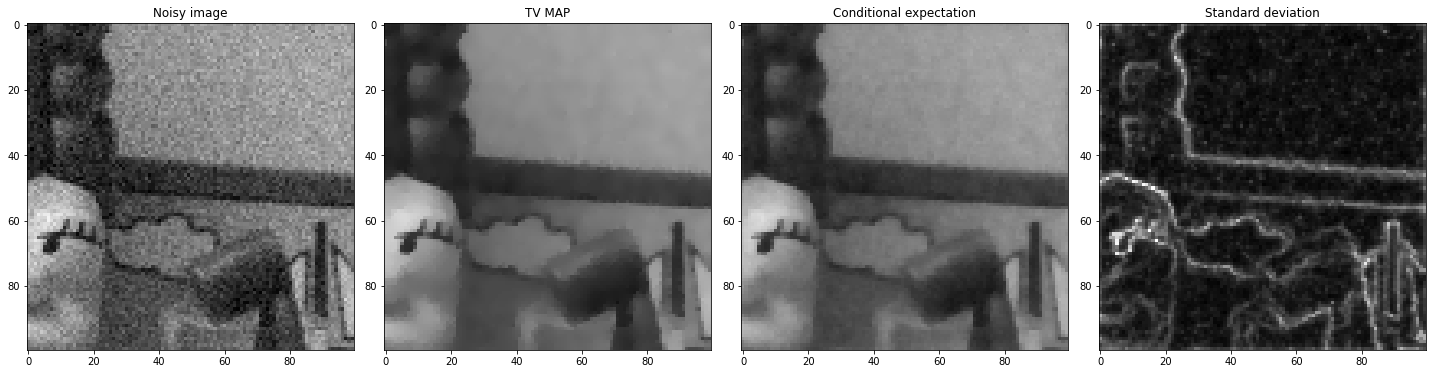

In [10]:
# Parameters for the MCMC
N = int(5e4)   # Choose N<1e4 for your experiments
alpha = 0.1  
lambd = 20     # TV regularization parameter 
opts =  dict(ub=ub, sigma=sigma, lambd=lambd)

# Metropolis algorithm
t0   = time.time()
x = np.random.rand(nr,nc) # Initialization
x,xmean,stdx = metropolis_TVL2(x,alpha,N,**opts)
t1 = time.time()
print("time spent: ", t1-t0)

# TV-MAP
u_tvmap = chambolle_pock_prox_TV("TVL2",ub,sigma**2*lambd,100)

# Print results
print4Images(ub, u_tvmap, xmean, stdx, 'Noisy image', 'TV MAP', 'Conditional expectation', 'Standard deviation', 20, 5)

## Sampling $e^{-\left(\lambda \mathrm{TV(u)+\|Au-u_0\|^2/{\sigma^2}}\right)}$ with diagonal A

In the following, we apply the same approach as above for an interpolation problem. We wish to sample from the distribution 
$$\pi(u) \propto e^{-\left(\lambda \mathrm{TV(u)+\|Au-u_0\|^2/{\sigma^2}}\right)}$$
where $A$ is a masking operator (diagonal matrix with $0$ and $1$ on the diagonal). 
Since $A$ acts independently on each pixel, we can use exactly the same approach as before, working in parallel on independent pixels (at distance >=2). Working with a non diagonal $A$ would be much more complex.

In the next cell we create an image with missing pixels and additive noise. We use a crop of the original image to accelerate the process. 

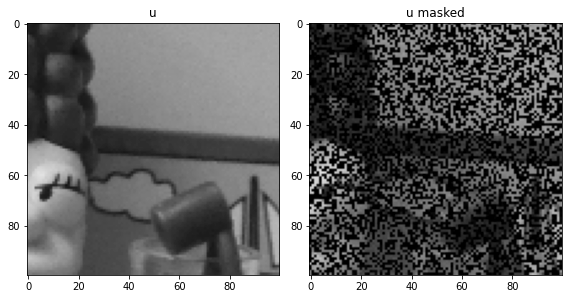

In [11]:
# Add mask and noise
mask  = np.random.rand(nr,nc)<0.5
sigma = 0.02
ub = u*mask + sigma*np.random.randn(nr,nc)

# Print images 
printImages(u, ub, "u", "u masked", 8, 8) 

The code to sample $\frac 1 Z e^{-\left(\lambda \mathrm{TV(u)+\|Au-u_0\|^2/{\sigma^2}}\right)}$ with diagonal $A$ is again very similar to the previous one.

In [12]:
#@title Sampling TVL2 with diagonal A 
######

def deltaTVL2A_pointwise(x,xtemp, **opts):
    """
    delta TV for TVL2 with diagonal A
    """
    mask = opts.get('mask', np.ones_like(x))
    ub = opts.get('ub', x)
    sigma = opts.get('sigma', 1)
    lambd = opts.get('lambd', 1)
    return  lambd*( TVaffected(xtemp) - TVaffected(x)) + 0.5*((mask*xtemp-ub)**2- (mask*x-ub)**2)/(sigma**2) 
    
def metropolis_TVL2A(x,alpha,N,**opts):
    """
    Metropolis algorithm using TVL2 with diagonal A
    calculates also mean and standard deviation
    """

    t_burnin = int(N/10)
    nr,nc = x.shape
    xmean = np.zeros((nr,nc))
    x2    = np.zeros((nr,nc))
 
    for t in range(N):
        x=transition_all_TV(x,alpha, deltaTVL2A_pointwise, **opts)
        # update the mean
        if t >= t_burnin:
            tb = t - t_burnin
            xmean = tb/(tb+1)*xmean + 1/(tb+1)*x
            x2    = tb/(tb+1)*x2 + 1/(tb+1)*x**2
    stdx = np.sqrt(x2 - xmean**2)
    return x,xmean,stdx 




In the next cell we run the Metropolis algorithm. We  also run the Chambolle-Pock TV2 algorithm for comparison purposes.

time spent:  36.90588879585266


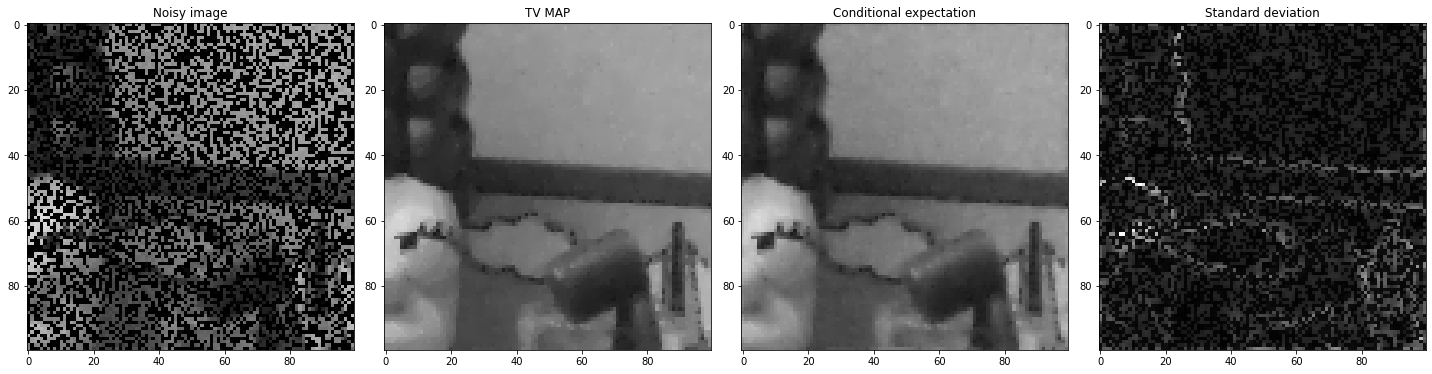

In [13]:
# Parameters for the MCMC
N = int(3e4)   # Choose N<1e4 for your experiments
alpha = 0.1  
lambd = 20
opts =  dict(ub=ub, sigma=sigma, lambd=lambd, mask=mask)

# Metropolis algorithm
t0   = time.time()
x = np.random.rand(nr,nc)
x,xmean,stdx = metropolis_TVL2A(x,alpha,N,**opts)
t1 = time.time()
print("time spent: ", t1-t0)

# TV-MAP
opt = dict(mask=mask)
u_tvmap = chambolle_pock_prox_TV("TVL2A",ub,sigma**2*lambd,200, **opt)

# Print results
print4Images(ub, u_tvmap, xmean, stdx, 'Noisy image', 'TV MAP', 'Conditional expectation', 'Standard deviation', 20, 5)